In [1]:
# mount on google drive
# from google.colab import drive
# drive.mount('/content/drive/')


In [1]:
import os
os.chdir('..')
import time
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from utils.tiff_io import readTiff, writeTiff
from utils.acc_eval import get_sample, acc_sample
from utils.imgPatch import imgPatch


In [2]:
## test image and test sample
path_S2_img = 'data/test-data(demo)/T49QGF_20191017_6Bands_Urban_Subs.tif'
path_water_sam = 'data/test-data(demo)/T49QGF_20191017_6Bands_Urban_Subs_Water_Sam.csv'
path_land_sam = 'data/test-data(demo)/T49QGF_20191017_6Bands_Urban_Subs_Land_Sam.csv'
# pre-trained model
path_model = 'models/pretrained_model/PreTrained_model_6bands.h5'
path_result_map = 'data/test-data(demo)/result_map.tif'
## super parameters
patch_size = 512
overlay = 80  # the overlay area between neighboring patches

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


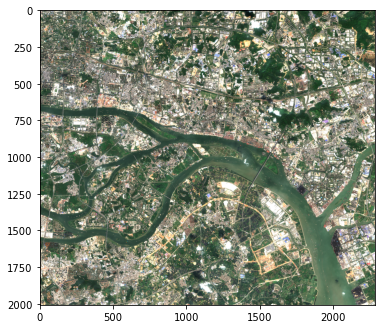

In [3]:
# Load and prepare the satellite image data
#################################################################
img_src, sen2_img = readTiff(path_in=path_S2_img)
sen2_img = np.float32(np.clip(sen2_img/10000, a_min=0, a_max=1))  ### normalization
plt.figure(figsize=(6,6))
plt.imshow(sen2_img[:, :, (2,1,0)]*5)
### load the pretrained model
model = tf.keras.models.load_model(path_model)
# model.summary()


In [4]:
## surface water mapping from sentinel-2 image
imgPatch_ins = imgPatch(sen2_img, patch_size, overlay)
patch_list, start_list, img_patch_row, img_patch_col = imgPatch_ins.toPatch()
result_patch_list = [model(patch[np.newaxis, :]) for patch in patch_list]
result_patch_list = [np.squeeze(patch, axis = 0) for patch in result_patch_list]
pro_map = imgPatch_ins.toImage(result_patch_list, img_patch_row, img_patch_col)
cla_map = np.where(pro_map>0.5, 1, 0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


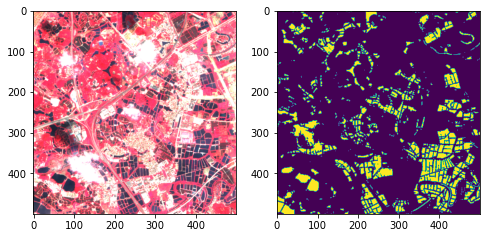

In [7]:
### show the result
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(sen2_img[1500:2000, 1000:1500, (3,2,1)]*6.5)
plt.subplot(1,2,2)
plt.imshow(cla_map[1500:2000, 1000:1500, 0])


Overall accuracy: 0.998
Confusion matrix: [[1.     0.0043]
 [0.     0.9957]]


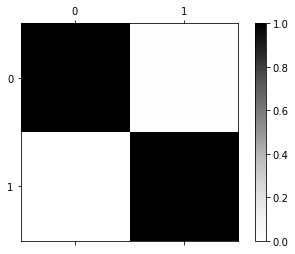

In [8]:
## show the accuracy
sam_water = get_sample(path_sam=path_water_sam,label=1)
sam_land = get_sample(path_sam=path_land_sam,label=0)
sam = np.vstack((sam_water,sam_land))
acc,confus_mat_per = acc_sample(cla_map, sam)
print('Overall accuracy:', acc)
print('Confusion matrix:', np.around(confus_mat_per,4))
plt.matshow(confus_mat_per,cmap=plt.cm.Greys, fignum=0)
plt.colorbar()

In [ ]:
## save the result
# writeTiff(cla_map[:,:,0], im_geotrans, im_proj, path_result_map)
